In [35]:
import pandas as pd
import numpy as np
from math import sqrt
import joblib
from geopy.distance import distance
from sklearn.model_selection import train_test_split
import datetime
import matplotlib
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import AdaBoostRegressor
from regression import Regression

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [40]:
cols = ['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count']

In [36]:
random_dataset = joblib.load('data/larger_dataset.joblib')

## Data Processing & Analysis

In [37]:
date_time_format = '%Y-%m-%d %H:%M:%S UTC'
time_format = '%H'

def getDistance(pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude):
    # Define the two points
    pickup = (pickup_latitude, pickup_longitude)
    dropoff = (dropoff_latitude, dropoff_longitude)
    
    #Return distance in meters
    return distance(pickup, dropoff).kilometers  
    
def datetime2HoursOnly(date_time):
    date = datetime.datetime.strptime(date_time, date_time_format)
    return date.strftime(time_format)
    
def valid_row(longitude, latitude):
    return (longitude < -70) and (longitude > -78) and (latitude > 38) and (latitude < 45)

In [44]:
# Cleaning Up Data: Common Errors are:
# - Lat & Long being Switched
# - Decimal Place of Lat / Long off by a factor of 10
# - 0000 as Lat or Long (Removed)
random_dataset["valid"] = random_dataset.apply(lambda row : valid_row(row['pickup_longitude'],
       row['pickup_latitude']) and valid_row(row['dropoff_longitude'], row['dropoff_latitude']), axis=1 )

dataset = random_dataset[random_dataset.valid == True].drop(columns=["valid"], inplace=False)

In [ ]:
dataset['distance'] = dataset.apply(lambda row : getDistance(row['pickup_longitude'],
       row['pickup_latitude'], row['dropoff_longitude'], row['dropoff_latitude']), axis=1)

dataset['time'] = dataset.apply(lambda row : datetime2HoursOnly(row['pickup_datetime']), axis=1)
dataset.drop(columns=['pickup_datetime'], inplace=True)

dataset = dataset[dataset.distance > 0]
dataset = dataset[dataset.passenger_count > 0]

In [45]:
#Basis Analysis: Distribution of Passenger Count, distance pickup time to fare amount
dataset.plot.scatter(x="distance", y="fare_amount")

KeyError: 'distance'

In [ ]:
dataset[['passenger_count', 'fare_amount']].groupby('passenger_count').mean().reset_index()

## Model Selection

In [ ]:
X=dataset.iloc[:,2:9]
y=dataset['fare_amount']

__Linear Regression__

In [ ]:
model = Regression(X=X, y=y, model_type="linear_regression", normalize=True)
model.fit(model.X_train, model.y_train)
y_pred = model.predict(model.X_test)

train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Default Parameters Training_Set {}".format(train_result))
print("Default Parameters Test_Set {}".format(test_result))

__Stochastic Gradient Descent__

In [ ]:
model = Regression(X=X, y=y, model_type="stochastic_gradient_descent", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

__SVR__

In [14]:
model = Regression(X=X, y=y, model_type="svr", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "C": [1e0, 1e1, 1e2, 1e3], 
    "gamma": np.logspace(-2, 2, 5)}

model = Regression(X=X, y=y, model_type="svr", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))

Training_Set mse = 37.128493406794576 & mae = 2.6023862341407553 & rmse = 6.093315469167387
Test_Set mse = 32.03180733030998 & mae = 2.57193630050366 & rmse = 5.659664948591036
Best Parameters Training_Set: mse = 15.338768084883716 & mae = 1.6910571490028228 & rmse = 3.9164739351722635
Best Parameters Test_Set: mse = 14.517227589995496 & mae = 2.0566943649538656 & rmse = 3.810147974816135


In [12]:
print(best_parameters)

{'C': 100.0, 'gamma': 0.01, 'kernel': 'linear'}


__Decision Tree Regression__

In [12]:
model = Regression(X=X, y=y, model_type="decision_tree", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))


grid_param = {
    'max_depth' : [None, 3, 5, 10],
    "criterion": ["mse", "friedman_mse"]}

model = Regression(X=X, y=y, model_type="decision_tree", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)

Training_Set mse = 1.5778675718805345e-31 & mae = 2.9376189417280564e-17 & rmse = 3.972238124635197e-16
Test_Set mse = 31.14100620155039 & mae = 3.057777777777778 & rmse = 5.5804127268106605
Best Parameters Training_Set: mse = 1.5778675718805345e-31 & mae = 2.9376189417280564e-17 & rmse = 3.972238124635197e-16
Best Parameters Test_Set: mse = 25.98646520241171 & mae = 2.9210077519379847 & rmse = 5.097692144727034
{'criterion': 'mse', 'max_depth': 5}


__Ridge Regression__

In [13]:
model = Regression(X=X, y=y, model_type="ridge", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3], 
    "solver": ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

model = Regression(X=X, y=y, model_type="ridge", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)

Training_Set mse = 51.01913349176767 & mae = 3.4900369476110233 & rmse = 7.142767915294999
Test_Set mse = 31.207155601140034 & mae = 3.2147132807948244 & rmse = 5.586336509837197
Best Parameters Training_Set: mse = 51.01913349176767 & mae = 3.4900369476110233 & rmse = 7.142767915294999
Best Parameters Test_Set: mse = 31.207155601140034 & mae = 3.2147132807948244 & rmse = 5.586336509837197
{'alpha': 1.0, 'solver': 'svd'}


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__LASSO__

In [14]:
model = Regression(X=X, y=y, model_type="lasso", normalize=True)
model.fit(model.X_train, model.y_train)

y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Training_Set {}".format(train_result))
print("Test_Set {}".format(test_result))

grid_param = {
    "alpha": [1e0, 0.1, 1e-2, 1e-3]}

model = Regression(X=X, y=y, model_type="lasso", normalize=True)
best_parameters = model.perform_grid_search_cross_validation(model.X_train, model.y_train, grid_param, scoring=None)

model.update_with_parameters(best_parameters)
y_pred = model.predict(model.X_test)
train_result = model.validate_prediction(model.y_train, model.predict(model.X_train))
test_result = model.validate_prediction(model.y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))
print(best_parameters)

Training_Set mse = 54.62464148275521 & mae = 3.784503226998413 & rmse = 7.390848495454037
Test_Set mse = 38.71925279001341 & mae = 3.600724077158814 & rmse = 6.222479633555533
Best Parameters Training_Set: mse = 54.62464148275521 & mae = 3.784503226998413 & rmse = 7.390848495454037
Best Parameters Test_Set: mse = 38.71925279001341 & mae = 3.600724077158814 & rmse = 6.222479633555533
{'alpha': 1.0}


/anaconda3/envs/ml-everything/lib/python3.6/site-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__Ensemble Methods__

__Gradient Boosting Regression__

RMSE: 3.6723


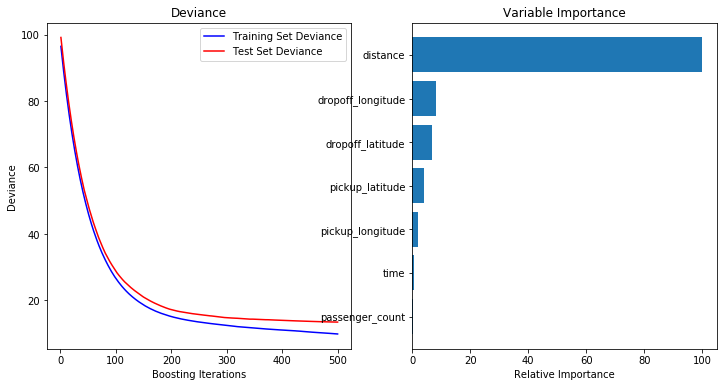

Index(['pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'distance', 'time'],
      dtype='object')


array([  1.92376991,   4.17268377,   8.02622462,   6.91417773,
         0.16158486, 100.        ,   0.69787112])

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}

clf = ensemble.GradientBoostingRegressor(**params)
clf.fit(X_train, y_train)

rmse = sqrt(mean_squared_error(y_test, clf.predict(X_test)))
print("RMSE: %.4f" % rmse)

test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# Plot feature importance
feature_importance = clf.feature_importances_
feature_names = dataset.columns[2:9]
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

__adaBoosting__

In [31]:
def validate_prediction(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)

    return "mse = {mse} & mae = {mae} & rmse = {rmse}".format(mse=mse, mae=mae, rmse=sqrt(mse))


In [34]:
regr = AdaBoostRegressor(base_estimator=model.model)
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test) 

train_result = validate_prediction(y_train, regr.predict(X_train))
test_result = validate_prediction(y_test, y_pred)

print("Best Parameters Training_Set: {}".format(train_result))
print("Best Parameters Test_Set: {}".format(test_result))

Best Parameters Training_Set: mse = 30.192505152109664 & mae = 3.852974980271832 & rmse = 5.494770709693869
Best Parameters Test_Set: mse = 42.61193588856432 & mae = 4.33544539873847 & rmse = 6.527781850564885
